In [1]:
# THIS IS NOT ORIGINAL WORK, IT IS A MODIFIED VERSION OF THE SCRIPT BY FISCHBACH ET AL. (2021)
# get current timestamp for proper documentation of testing and validation results
from datetime import datetime

currentTime = str(datetime.now())
model_save_name = 'causal_classifier_' + currentTime + '.bin'
path = F"/content/gdrive/My Drive/Causality Classification/"

## Setup

Load the transformers library from HuggingFace.


In [2]:
import sys, os

#!{sys.executable} -m pip install --user watermark # altered
#!{sys.executable} -m pip install --user transformers # altered
#!{sys.executable} -m pip install --user spacy # altered

# Make sure that python can load the required packages
# we need to specify the location for which the python packages will be installed
sys.path.insert(0, os.path.expanduser('~/.local/lib/python3.6/site-packages'))

!python3 -m spacy download en_core_web_sm

# Use Pos Tagging ?
# use_pos_tags = True # altered
use_pos_tags = False

2022-12-22 11:27:13.562834: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 4.7 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
#import transformers # altered
!pip install transformers # altered
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# packages for adding pos tags
import spacy

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.0 MB/s 
     |████████████████████████████████| 182 kB 87.6 MB/s 
     |████████████████████████████████| 7.6 MB 84.5 MB/s 


device(type='cuda', index=0)

## Data Exploration

Import Causal Sentences from our annotation platform.


In [4]:
df = pd.read_csv("annotation_causal.csv", encoding='utf-8') 

# As the sentences are labeled by multiple annotators, we need to merge all labels into one colum.
# looks like = 1,1,1,1,1...
df['Label'] = df[df.columns[1:7]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

# After that we just need to use the first label of the merged colum.
# Different labeling decisions are already discussed in our labeling process.
for index, row in df.iterrows():
    df.at[index,'Label'] = int(float(row['Label'][0:3]))

# to make further processing easier we can drop unncessary columns
df.drop(df.columns[[1,2,3,4,5,6]], axis=1, inplace=True)

df.head()

,Sentence,Label
0,A specification of the application's functiona...,0
1,"First, it is anticipated that the SRS will be ...",0
2,Designers will use the information recorded he...,0
3,"Second, the client for the project, the librar...",0
4,The SRS will serve to establish a basis for ag...,0


In [5]:
df.shape

(14983, 2)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


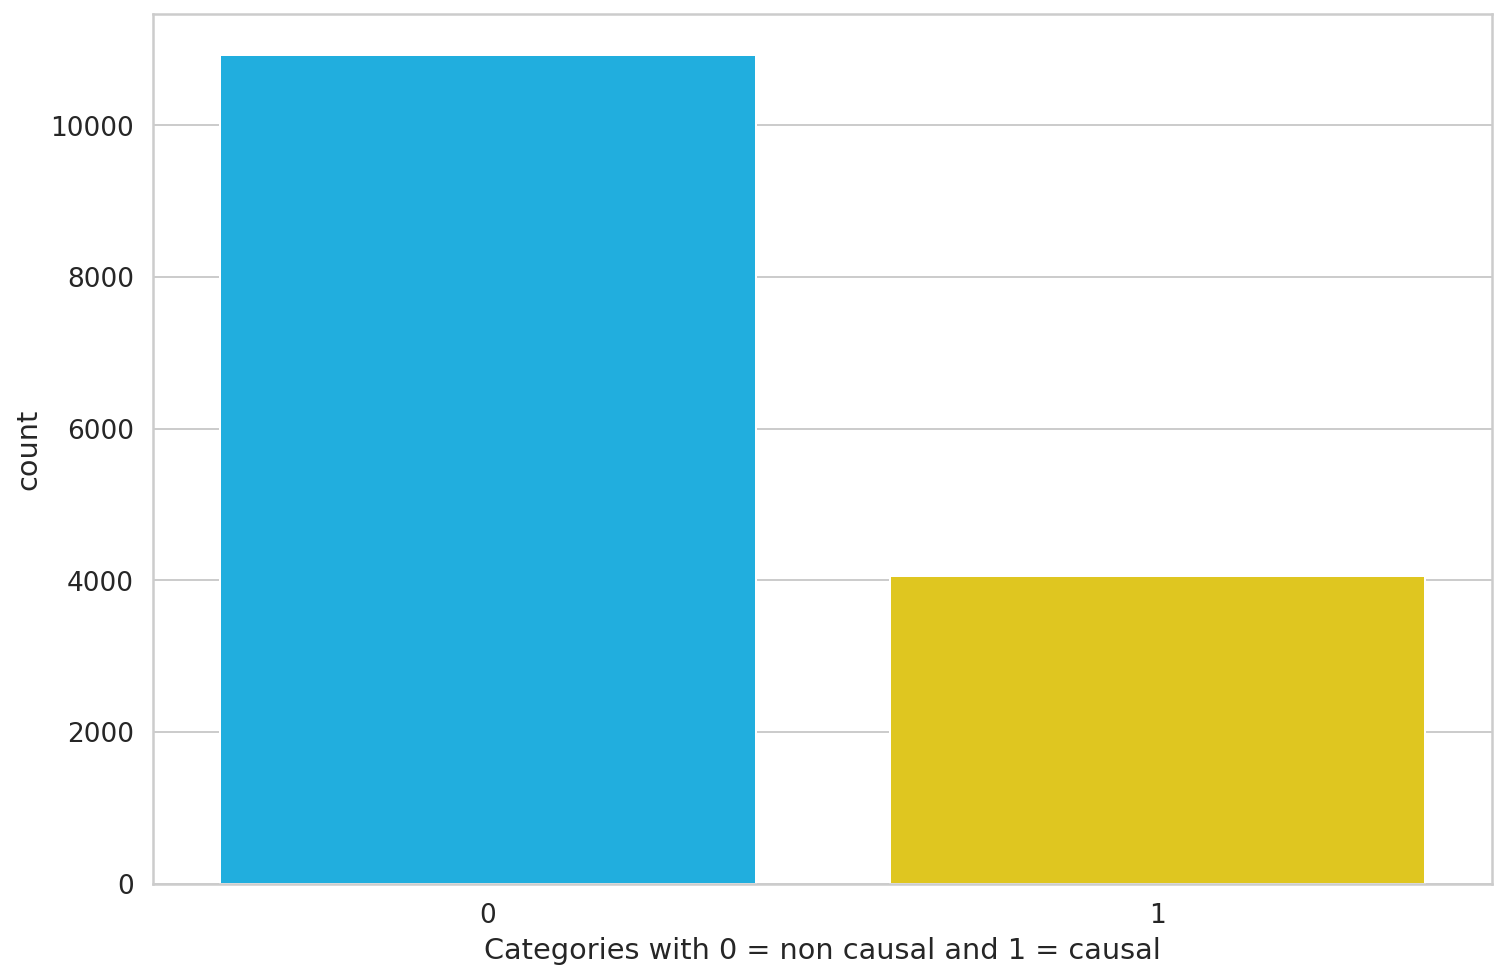

In [6]:
# Check for class imbalance
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(df.Label)
plt.xlabel('Categories with 0 = non causal and 1 = causal');

In [7]:
class_names = ['not causal', 'causal']

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


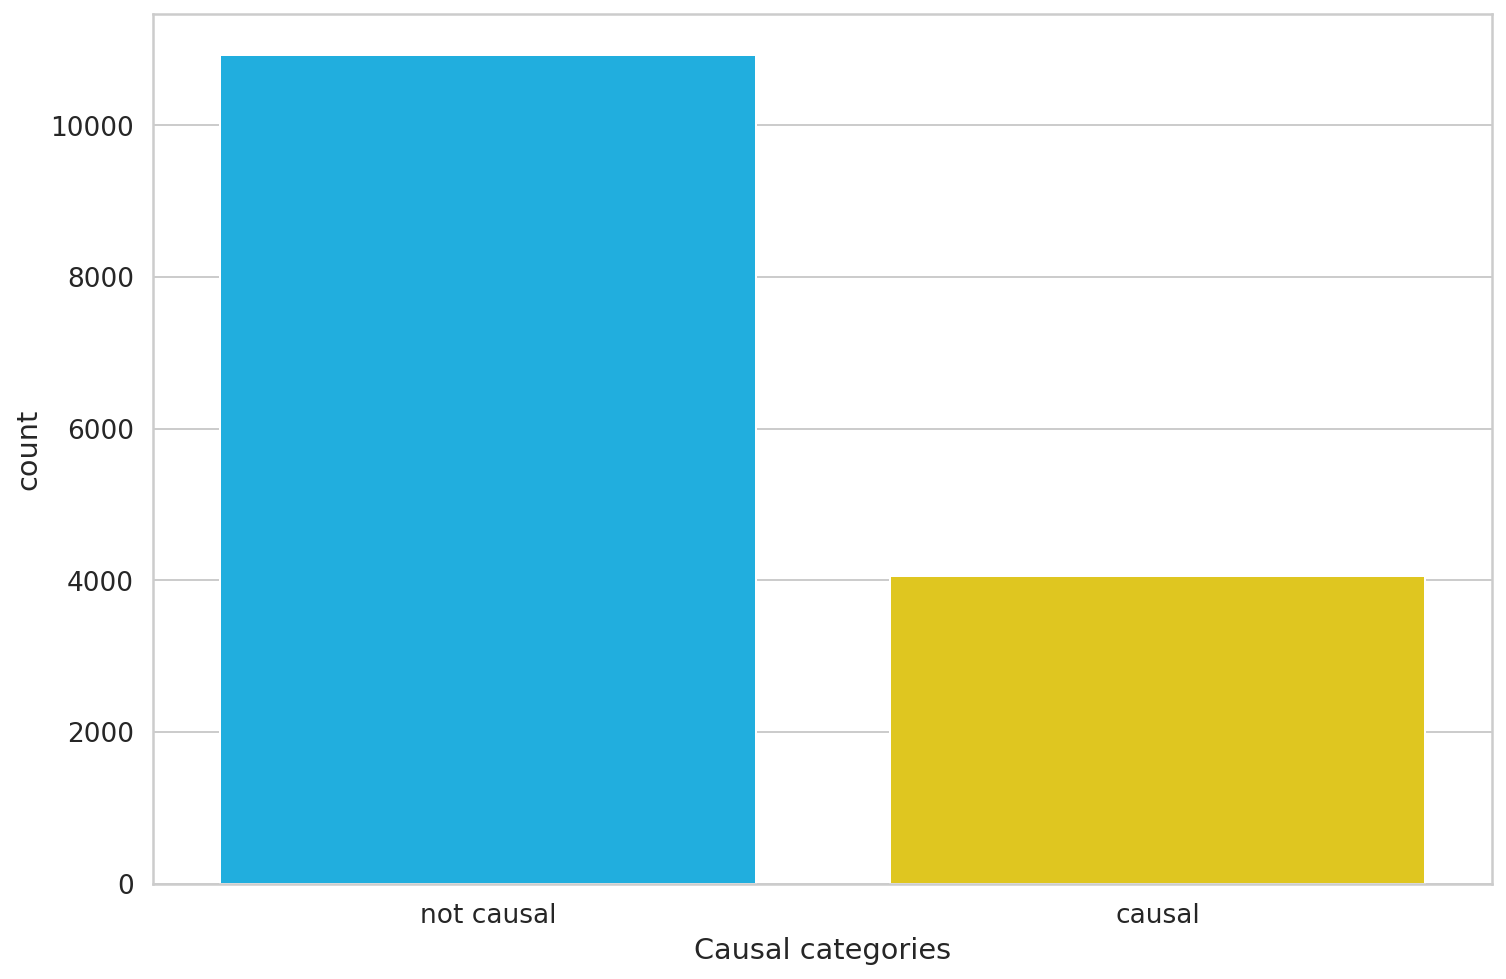

In [8]:
ax = sns.countplot(df.Label)
plt.xlabel('Causal categories')
ax.set_xticklabels(class_names);

Random under-sampling:
0    10923
1     4060
Name: Label, dtype: int64


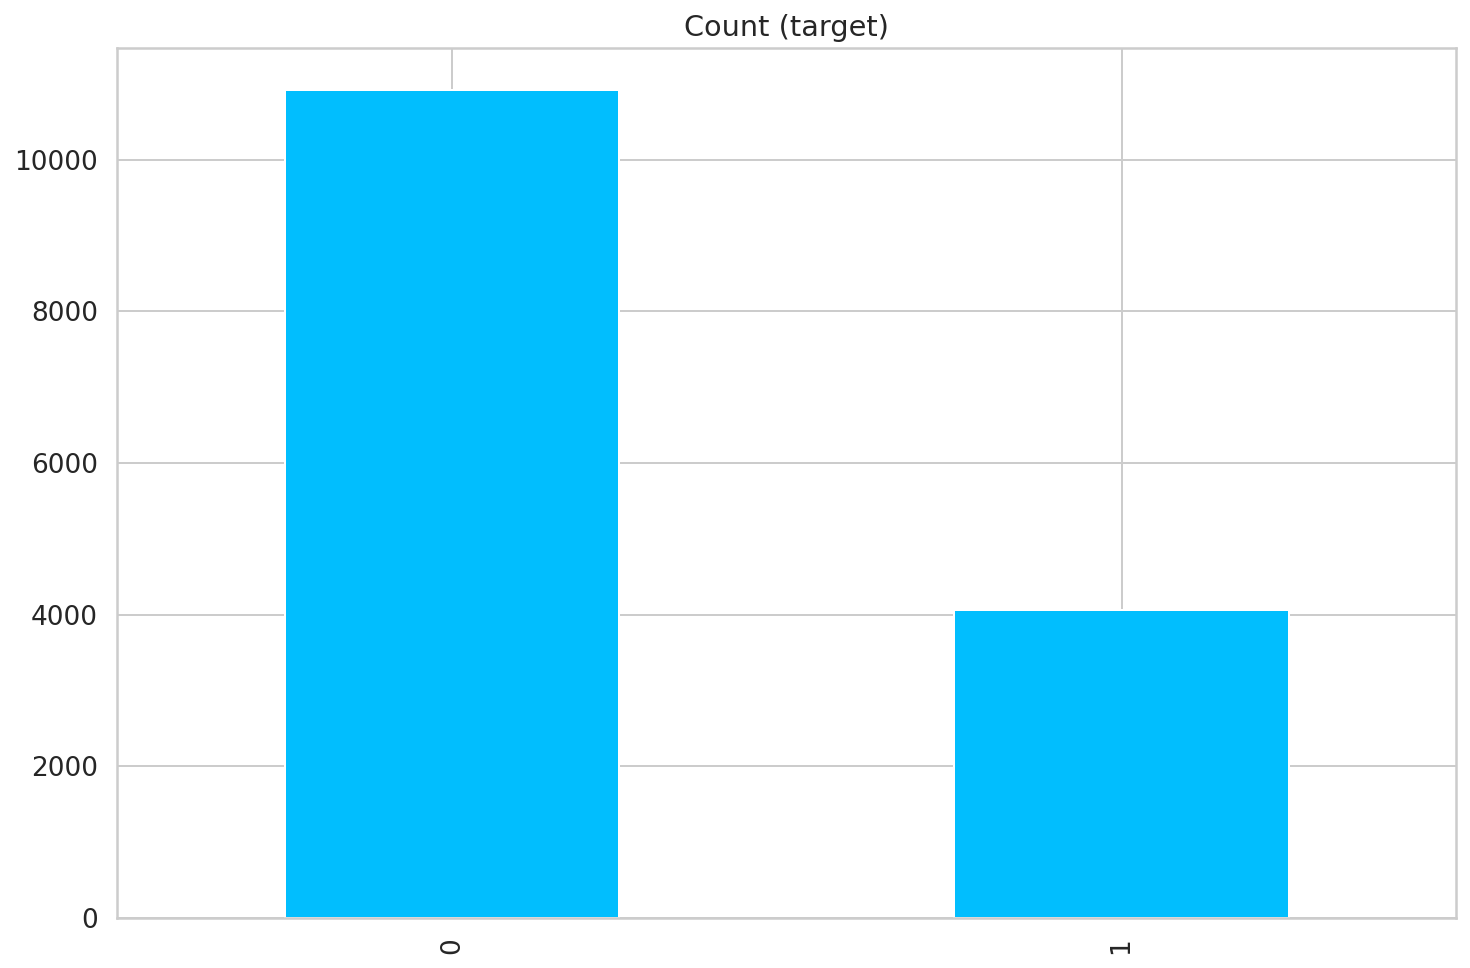

In [9]:
# Class count
count_class_non_causal, count_class_causal = df.Label.value_counts()

# Divide by class
df_class_non_causal = df[df['Label'] == 0]
df_class_causal = df[df['Label'] == 1]

# undersample "non causal" class
# df_class_non_causal_under = df_class_non_causal.sample(count_class_causal) # altered
df_class_non_causal_under = df_class_non_causal # altered
df_undersampled = pd.concat([df_class_non_causal_under, df_class_causal], axis=0)

print('Random under-sampling:')
print(df_undersampled.Label.value_counts())

df_undersampled.Label.value_counts().plot(kind='bar', title='Count (target)');

df = df_undersampled

In [10]:
# add POS Tags to sentences
import en_core_web_sm

if use_pos_tags == True:
    #nlp = spacy.load('en_core_web_sm')
    nlp = en_core_web_sm.load()

    for index, row in df.iterrows():
        doc = nlp(row['Sentence'])
        new_sentence = ""

        for token in doc:
          new_sentence += token.text + "_" + token.dep_ + " "

        df.at[index,'Sentence'] = new_sentence

In [11]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [12]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

print(df.shape)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

(14983, 2)


In [13]:
sample_txt = 'if_DET the_ADJ if sun_NOUN is_VERB shining, I will go to the beach characteristically._.'

In [14]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=62,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
  truncation=True
)

print(tokenizer.unk_token_id)

print(tokenizer.tokenize(sample_txt))
encoding.keys()

encoding.items

100
['if', '_', 'DE', '##T', 'the', '_', 'AD', '##J', 'if', 'sun', '_', 'NO', '##UN', 'is', '_', 'V', '##ER', '##B', 'shining', ',', 'I', 'will', 'go', 'to', 'the', 'beach', 'characteristic', '##ally', '.', '_', '.']


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


<bound method BatchEncoding.items of {'input_ids': tensor([[  101,  1191,   168, 18581,  1942,  1103,   168,  5844,  4538,  1191,
          3336,   168, 24819, 27370,  1110,   168,   159,  9637,  2064, 10825,
           117,   146,  1209,  1301,  1106,  1103,  4640,  7987,  2716,   119,
           168,   119,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}>

### Choosing Sequence Length



In [15]:
token_lens = []

for txt in df.Sentence:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


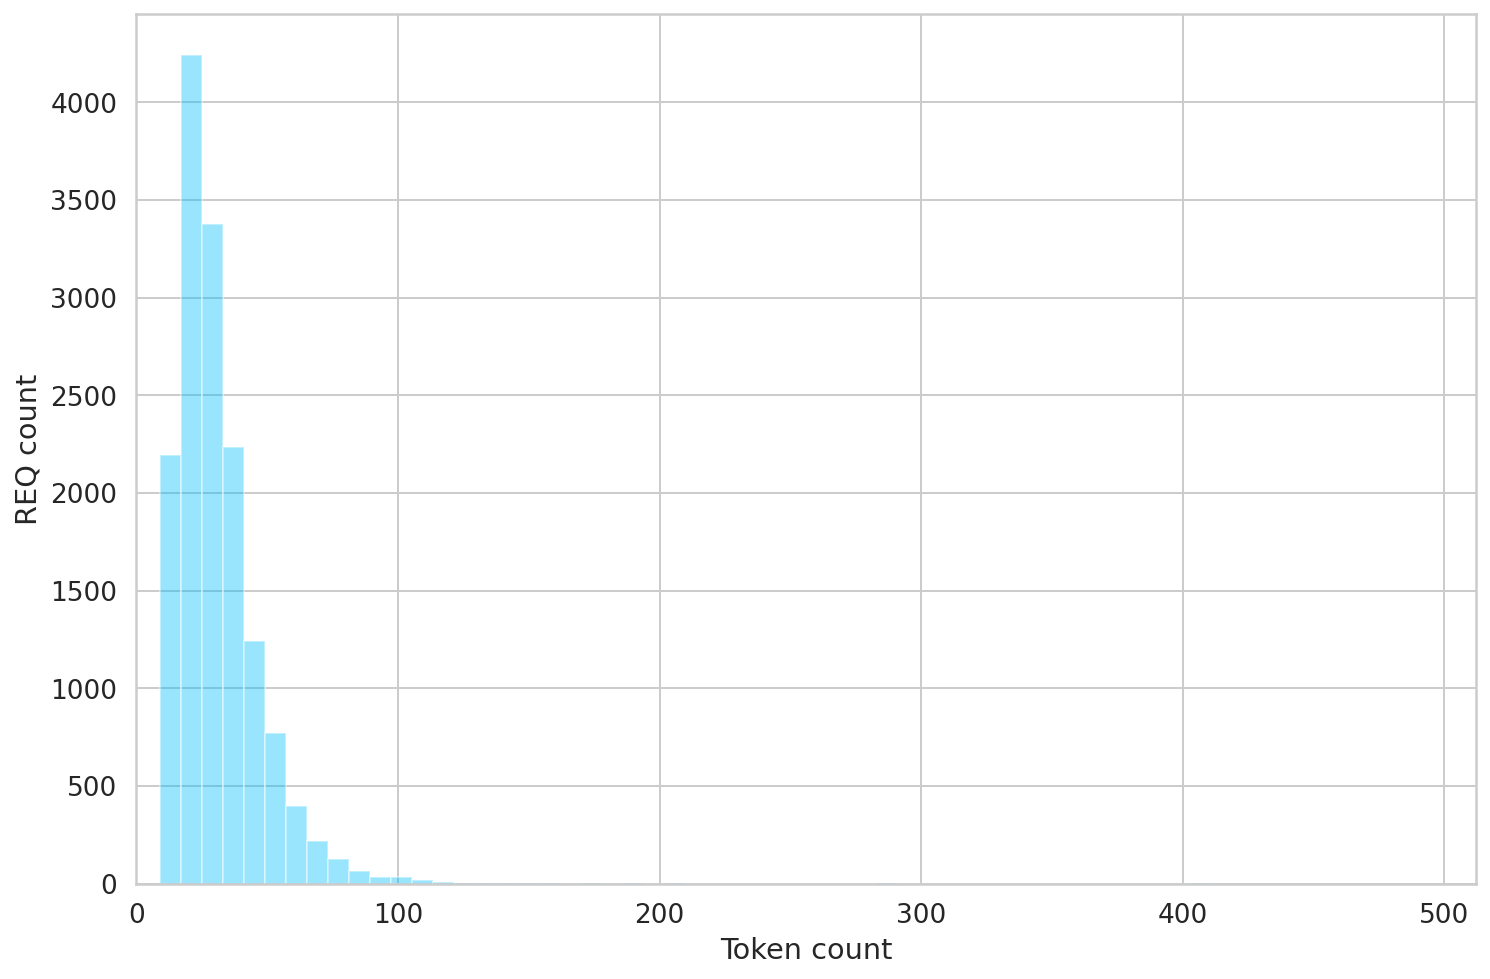

In [16]:
sns.distplot(token_lens, kde=False)
plt.xlim([0, 512]);
plt.xlabel('Token count');
plt.ylabel('REQ count');

In [17]:
MAX_LEN = 384

In [18]:
class CausalDataset(Dataset):

  def __init__(self, sentences, targets, tokenizer, max_len):
    self.sentences = sentences
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.sentences)
  
  def __getitem__(self, item):
    sentence = str(self.sentences[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      sentence,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'requirement_text': sentence,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [19]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

We also need to create a couple of data loaders. Here's a helper function to do it:

In [20]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = CausalDataset(
    sentences=df.Sentence.to_numpy(),
    targets=df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [21]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

## Causality Classification of Requirements

In [22]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
class CausalClassifier(nn.Module):

  def __init__(self, n_classes):
    super(CausalClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False # altered
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [25]:
model = CausalClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Training

In [26]:
EPOCHS = 8 # altered
# EPOCHS = 20 # altered
LEARNING_RATE = 2e-5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [28]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [29]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['epoch'].append(epoch)  
  history['batch_size'].append(BATCH_SIZE)  
  history['learning_rate'].append(LEARNING_RATE)
  history['train_acc'].append(train_acc.item())
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc.item())
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), model_save_name)
    best_accuracy = val_acc

pd.DataFrame(history).to_csv('training_results_' + currentTime + '.csv', mode='a')

Epoch 1/8
----------
Train loss 0.47097505200902623 accuracy 0.7928416485900217
Val   loss 0.38505197213368214 accuracy 0.8264352469959947

Epoch 2/8
----------
Train loss 0.3699321253796419 accuracy 0.8504922409477724
Val   loss 0.3702776520017614 accuracy 0.8558077436582109

Epoch 3/8
----------
Train loss 0.30617856776962676 accuracy 0.8898715167695644
Val   loss 0.40953239192195395 accuracy 0.849799732977303

Epoch 4/8
----------
Train loss 0.2480370453322927 accuracy 0.925830135157684
Val   loss 0.5063401057602878 accuracy 0.8417890520694259

Epoch 5/8
----------
Train loss 0.205749038644135 accuracy 0.9469380944435174
Val   loss 0.5472212354949815 accuracy 0.8457943925233644

Epoch 6/8
----------
Train loss 0.17347885220932463 accuracy 0.9592858334723844
Val   loss 0.5540311089815929 accuracy 0.8504672897196262

Epoch 7/8
----------
Train loss 0.15508982833226523 accuracy 0.9651259803103621
Val   loss 0.6519247978687921 accuracy 0.8457943925233644

Epoch 8/8
----------
Train loss

## Evaluation



In [30]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

text_file = open("test_acc.txt", "a")
n = text_file.write('Test Accuracy of the best model (highest val accuracy): ' + str(test_acc.item()) + "\n")
text_file.close()

print(test_acc.item())

0.8165443629086057


In [31]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  requirement_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["requirement_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      requirement_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return requirement_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [32]:
y_requirement_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

len(y_requirement_texts)

1499

In [33]:
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_report.to_csv("classification_report_BERT.csv")

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

  not causal       0.88      0.86      0.87      1085
      causal       0.66      0.70      0.68       414

    accuracy                           0.82      1499
   macro avg       0.77      0.78      0.78      1499
weighted avg       0.82      0.82      0.82      1499



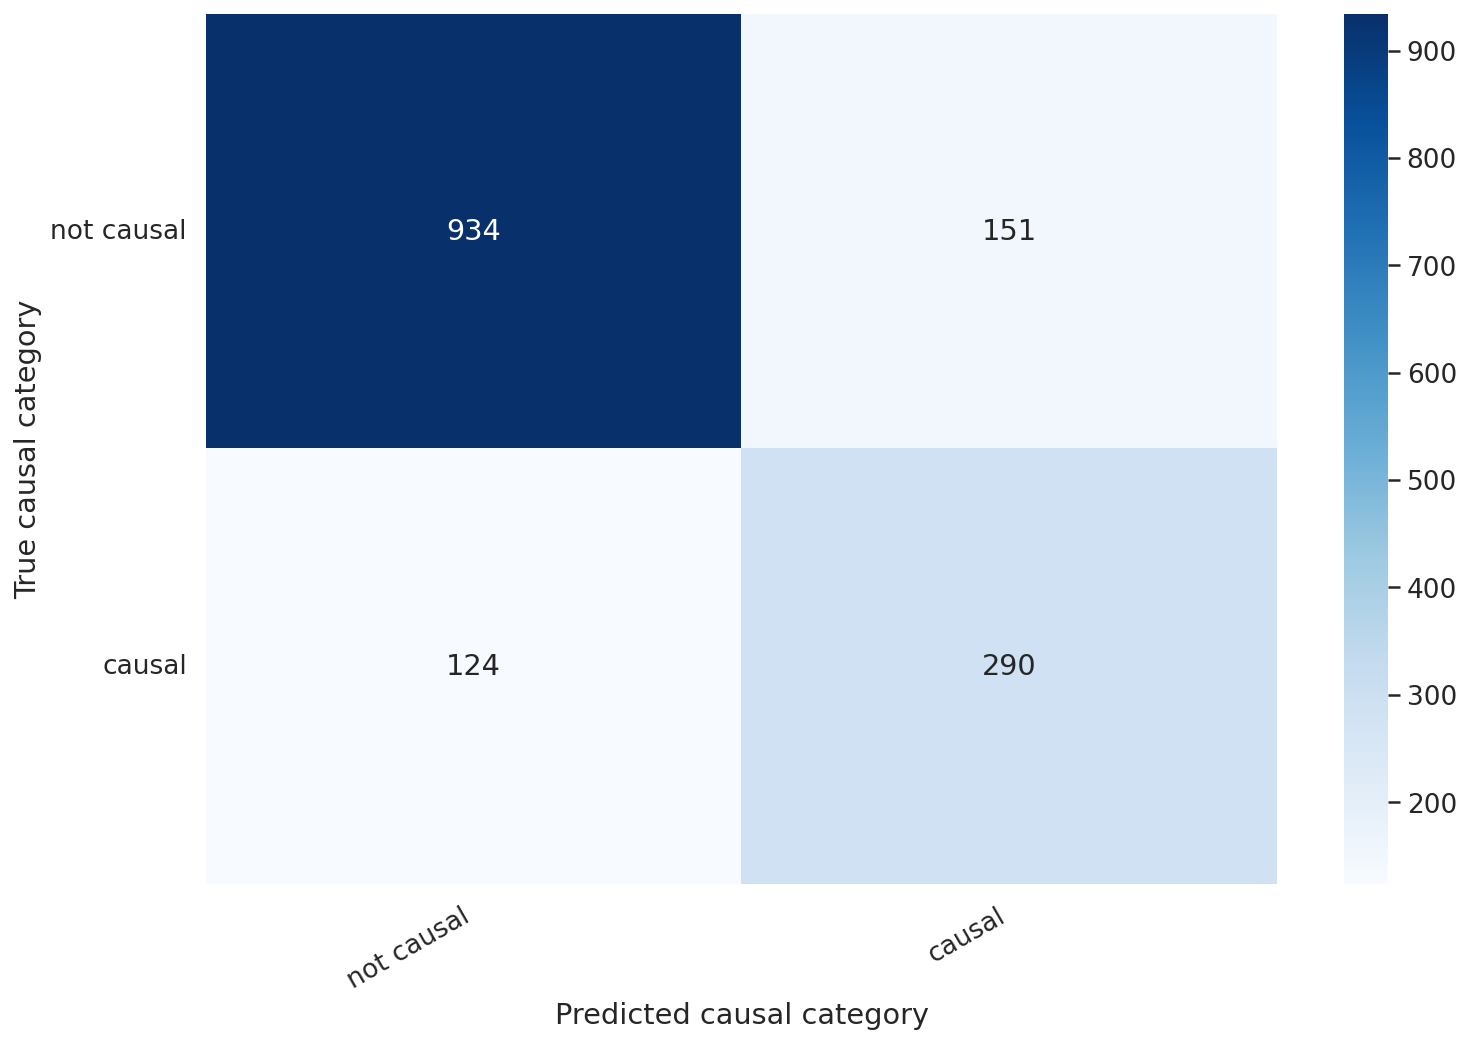

In [34]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True causal category')
  plt.xlabel('Predicted causal category');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

df_cm.to_csv("confusion_matrix.csv")

In [35]:
idx = 2

sentence_text = y_requirement_texts[idx]
true_label = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [36]:
# calculate AUC Score on test set

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

text_file = open("test_acc.txt", "a")
n = text_file.write('AUC Score of the best model (highest val accuracy): ' + str(roc_auc_score(y_test, y_pred)) + "\n")
text_file.close()

In [37]:
print("\n".join(wrap(sentence_text)))
print()
print(f'True sentiment: {class_names[true_label]}')

The Land Cover Classification System (LCCS, (Di Gregorio 2005)) and
the related ontology specified in Land Cover Macro Language (LCML) is
currently the most comprehensive, internationally applied and flexible
framework for land cover characterization.

True sentiment: not causal


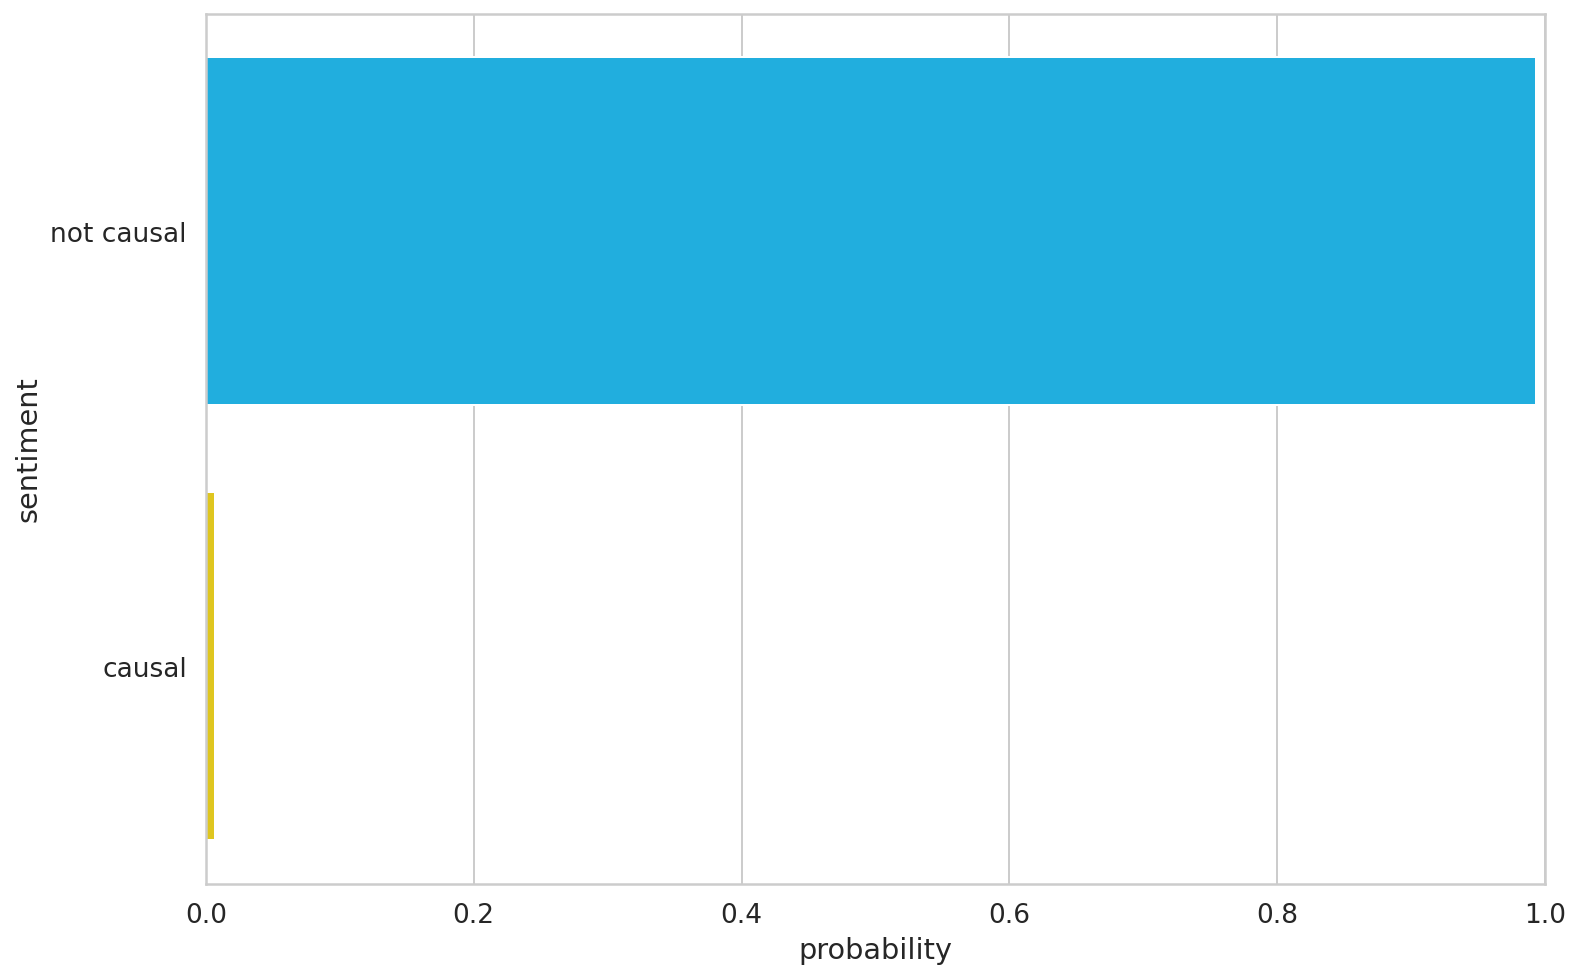

In [38]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
# lets test the normal regex approach on the test data set

# we iterate over all sentences and mark a sentence as causal in case it contains one of the cue phrases
# we define a list of cue phrase which we want to check
cue_phrases = ['if ', 'when ', 'because ', 'since ', 'therefore ', 'hence ', 'given ', 'where ', 
               'whose ', 'in order to ', 'in the case of ', 'due to ', 'needed ', 'require ', 'required ' 'during ',
               'in case of ', 'while ', 'thus ', 'as ', 'except ', 'forced by ', 'only for ', 'within ', 'after ', 'whenever ', 'which ', 'before ',
               'allows ', 'allow ', 'unless ', 'prior to', 'as long as ', 'depending on ', 'depends on ', 'result in ', 'increases ',
               'lead to ', 'thereby ', 'cause ', 'in the event ', 'once ', 'in such cases ', 'throughout ', 'improve ', 'to that end ', 'to this end']

# sentences to lower case 
y_requirement_texts = [entry.lower() for entry in y_requirement_texts]

y_pred_regex = pd.DataFrame(columns=['Sentence', 'Label'])

for row in y_requirement_texts:
    if any(substring in row for substring in cue_phrases):
      new_row = {'Sentence': row, 'Label': 1}
      y_pred_regex = y_pred_regex.append(new_row, ignore_index=True)
    else: 
      new_row = {'Sentence': row, 'Label': 0}
      y_pred_regex = y_pred_regex.append(new_row, ignore_index=True)     

from sklearn.preprocessing import LabelEncoder

Encoder = LabelEncoder()
y_pred_regex = Encoder.fit_transform(y_pred_regex['Label'])

report_regex = classification_report(y_test, y_pred_regex, target_names=class_names, output_dict=True)
df_report_regex = pd.DataFrame(report_regex).transpose()

df_report_regex.to_csv("classification_report_regex.csv")

print(classification_report(y_test, y_pred_regex))

              precision    recall  f1-score   support

           0       0.67      0.68      0.67       428
           1       0.64      0.62      0.63       384

    accuracy                           0.65       812
   macro avg       0.65      0.65      0.65       812
weighted avg       0.65      0.65      0.65       812

